In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)


27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
block_size = 3

def build_dataset(words):
    X = []
    Y = []
    context = [0] * block_size
    for w in words:

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(18)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182320, 3]) torch.Size([182320])
torch.Size([22953, 3]) torch.Size([22953])
torch.Size([22873, 3]) torch.Size([22873])


In [7]:
#MLP
n_embd = 20
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * 0.2
b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

b1.shape

18167


torch.Size([200])

In [76]:
# Training
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb, Yb = Xtrain[ix], Ytrain[ix]
    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer pre activation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    #lr = 0.1 if i < 100000 else 0.01
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.2847
  10000/ 200000: 2.1684
  20000/ 200000: 2.2235
  30000/ 200000: 2.2452
  40000/ 200000: 2.3168
  50000/ 200000: 2.2922
  60000/ 200000: 1.9245
  70000/ 200000: 2.0532
  80000/ 200000: 1.9871
  90000/ 200000: 2.1038
 100000/ 200000: 2.0530
 110000/ 200000: 2.1889
 120000/ 200000: 1.8381
 130000/ 200000: 1.8866
 140000/ 200000: 1.9827
 150000/ 200000: 2.3067
 160000/ 200000: 1.8316
 170000/ 200000: 1.7999
 180000/ 200000: 2.0091
 190000/ 200000: 2.5324


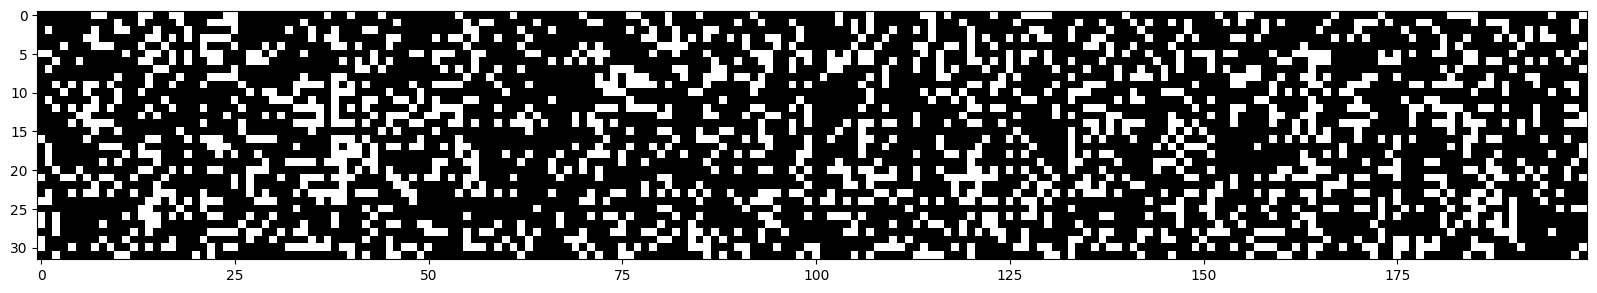

In [77]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([1378.,  260.,  169.,  139.,  113.,  117.,   95.,   87.,   76.,
          67.,   69.,   64.,   48.,   49.,   58.,   44.,   47.,   33.,
          38.,   43.,   47.,   47.,   33.,   45.,   65.,   37.,   41.,
          48.,   44.,   42.,   52.,   35.,   62.,   39.,   45.,   48.,
          61.,   49.,   46.,   65.,   78.,   68.,   81.,   91.,  108.,
         127.,  156.,  201.,  262., 1283.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

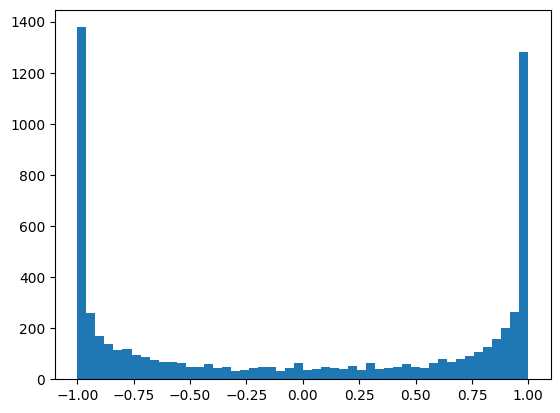

In [78]:
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   2.,   2.,   2.,   3.,   7.,   9.,  13.,  22.,  25.,  47.,
         58.,  83., 111., 170., 204., 236., 246., 274., 309., 373., 405.,
        375., 420., 411., 375., 398., 334., 274., 268., 232., 182., 144.,
        104.,  85.,  69.,  35.,  26.,  18.,  19.,  11.,   4.,   5.,   2.,
          3.,   2.,   0.,   0.,   0.,   1.]),
 array([-8.94386959, -8.56457823, -8.18528687, -7.8059955 , -7.42670414,
        -7.04741278, -6.66812141, -6.28883005, -5.90953869, -5.53024733,
        -5.15095596, -4.7716646 , -4.39237324, -4.01308187, -3.63379051,
        -3.25449915, -2.87520779, -2.49591642, -2.11662506, -1.7373337 ,
        -1.35804234, -0.97875097, -0.59945961, -0.22016825,  0.15912312,
         0.53841448,  0.91770584,  1.2969972 ,  1.67628857,  2.05557993,
         2.43487129,  2.81416265,  3.19345402,  3.57274538,  3.95203674,
         4.33132811,  4.71061947,  5.08991083,  5.46920219,  5.84849356,
         6.22778492,  6.60707628,  6.98636765,  7.36565901,  7.74495037,
 

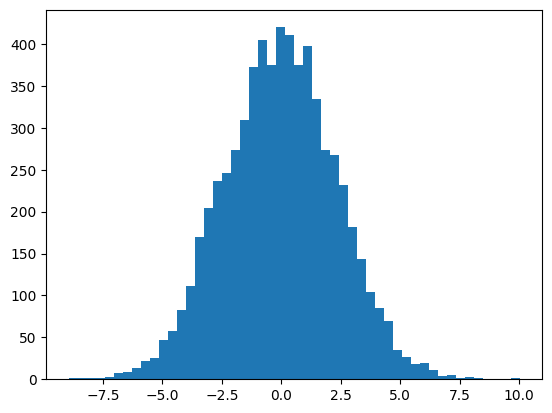

In [79]:
plt.hist(hpreact.view(-1).tolist(), 50)

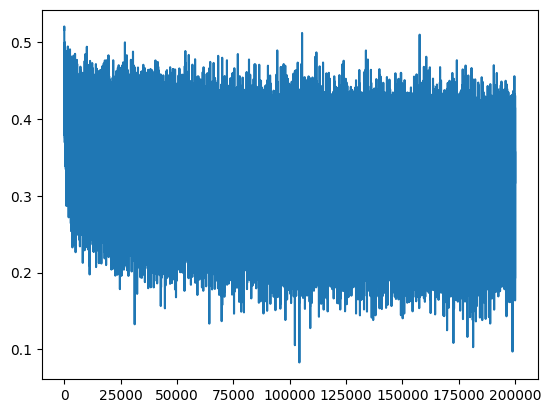

In [80]:
plt.plot(lossi)

In [81]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')
# split_loss('test')



train 2.0721189975738525
dev 2.138073444366455


In [53]:
# sample

for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(ix)
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(itos[k] for k in out))




anyda.
ayvin.
maxricer.
yaredininis.
yszie.
lola.
nia.
rae.
hoddreanashia.
malynn.
yameanna.
ahmergenenlee.
yoah.
hia.
samyr.
lar.
hoseyzieter.
daariohan.
lor.
arv.
